In [65]:
from pathlib import Path
import json
import pandas as pd
from datetime import datetime
from typing import List
import streamlit as st
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
DATA_PATH = Path('data') / '53526472'
MESSAGE_PATH = DATA_PATH / 'message.json'
CONVO_PATH = DATA_PATH / 'conversation.json'

with MESSAGE_PATH.open(encoding='utf-8') as f:
    msg_data = json.load(f)
    df_data_msg = pd.DataFrame(msg_data)

with CONVO_PATH.open(encoding='utf-8') as f:
    convo_data:dict = json.load(f)
    # df_convo= pd.DataFrame(convo_data)
df_data_msg.head(2)

,attachments,avatar_url,created_at,favorited_by,group_id,id,name,sender_id,sender_type,source_guid,system,text,user_id,platform,pinned_at,pinned_by,event,deleted_at,deletion_actor
0,[],https://i.groupme.com/1024x1024.jpeg.f5cfae0ce...,1668819447,[],53526472,166881944707556885,Joe Stassi,22089390,user,234392C6-8301-4FD5-AEB4-C8677CA0A802,False,thanks my man!!,22089390,gm,None,,NaN,NaN,NaN
1,"[{'loci': [[26, 11]], 'type': 'mentions', 'use...",https://i.groupme.com/960x960.jpeg.018a82eaf3b...,1668819169,"[10529832, 19901671, 22089390]",53526472,166881916925796885,J Money,12609853,user,1AF1E93C-E144-4FED-ACD6-86A33526E37B,False,Happy bday to a fine gent @Joe Stassi,12609853,gm,None,,NaN,NaN,NaN


In [27]:
members:dict = convo_data['members']
df_members = pd.DataFrame(members)
df_members.head(3)
id_map:pd.Series = df_members[['user_id','name']].set_index('user_id')['name']
df_id_map = df_members[['user_id','name']]

In [4]:
# How many muted?
# df_members[df_members.muted == True]

In [12]:
# df_data_msg[df_data_msg.system]

In [50]:

def has_image(data:List[dict]) -> bool:
    contains_image = False   
    for dicky in data:
       if dicky['type'] == 'image':
           contains_image = True
    return contains_image
# Attachmeent ype?

# print(len(df_data_msg))
COLS_TO_KEEP = ['attachments', 'created_at', 'favorited_by', 'name',  'sender_type', 'system','text', 'user_id', 'event']
df = df_data_msg[COLS_TO_KEEP].copy()
df = df[df.system == False].copy() # Don't care about system messages for this analysis.
df['created_at'] = df.created_at.apply(datetime.utcfromtimestamp)
df['like_count'] = df.favorited_by.apply(len)
df['has_attachement'] = df.attachments.apply( lambda x: len(x) > 0)
df['attachement_num'] = df.attachments.apply( lambda x: len(x))
df['has_image'] = df.attachments.apply(has_image)
df['char_count'] = df.text.apply(lambda x: len(x) if not x is None else False )
df['date_month'] = pd.PeriodIndex(year=df['created_at'].dt.year,month=df['created_at'].dt.month,freq='M')
# Add date cols:

df = df.merge(df_members[['user_id','nickname','name']],on='user_id',validate='m:1',how='left')

COLS_TO_DROP = ['system']
df = df.drop(columns=COLS_TO_DROP)

# Get image id
# image count
# word count
# Who is mentioned the most?
# Who mentions who the most

print(len(df))
df.head(2)

4341


,attachments,created_at,favorited_by,name_x,sender_type,text,user_id,event,like_count,has_attachement,attachement_num,has_image,char_count,date_month,nickname,name_y
0,[],2022-11-19 00:57:27,[],Joe Stassi,user,thanks my man!!,22089390,NaN,0,False,0,False,15,2022-11,Joe Stassi,Joe Stassi
1,"[{'loci': [[26, 11]], 'type': 'mentions', 'use...",2022-11-19 00:52:49,"[10529832, 19901671, 22089390]",J Money,user,Happy bday to a fine gent @Joe Stassi,12609853,NaN,3,True,1,False,38,2022-11,J Money,John Marston


In [75]:
d = df.groupby('name_y')['char_count'].mean().sort_values(ascending=False).to_frame().iloc[:10].reset_index()
d
fig = px.bar(d,x='name_y',y='char_count')

,name_y,char_count
0,Taeam Kang,389.333333
1,Miles Russo,384.000000
2,Austin Millisor,345.666667
3,Clayton McGee,256.333333
4,Terell Wilkins,225.142857
5,Lane Poche,203.750000
6,Nick Baldwin,191.142857
7,Andrew Searles,172.909091
8,Nic Brooksher,168.417910
9,Diego Matus,164.420000


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'name_y=%{x}<br>char_count=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'x': array(['Taeam Kang', 'Miles Russo', 'Austin Millisor', 'Clayton McGee',
                          'Terell Wilkins', 'Lane Poche', 'Nick Baldwin', 'Andrew Searles',
                          'Nic Brooksher', 'Diego Matus'], dtype=object),
              'xaxis': 'x',
              'y': array([389.33333333, 384.        , 345.66666667, 256.33333333, 225.14285714,
                          203.75      , 191.14285714, 172.90909091, 168.41791045, 164.42      ]),
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'name_y'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'char_count'}}}
})

In [60]:
d = df.groupby('date_month')['created_at'].count().to_frame().reset_index()

TypeError: float() argument must be a string or a real number, not 'Period'

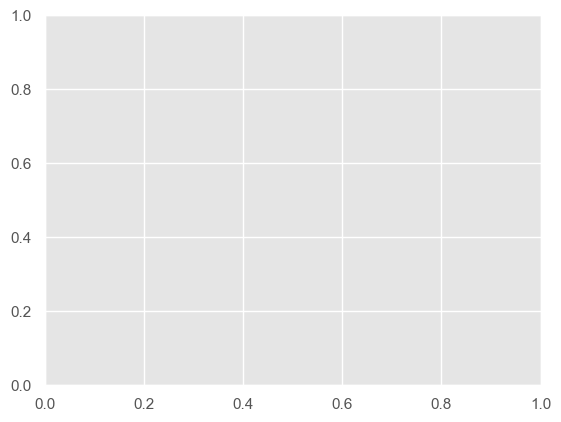

In [72]:
# plt.plot(d.date_month,d.created_at)

TypeError: Invalid object type at position 0

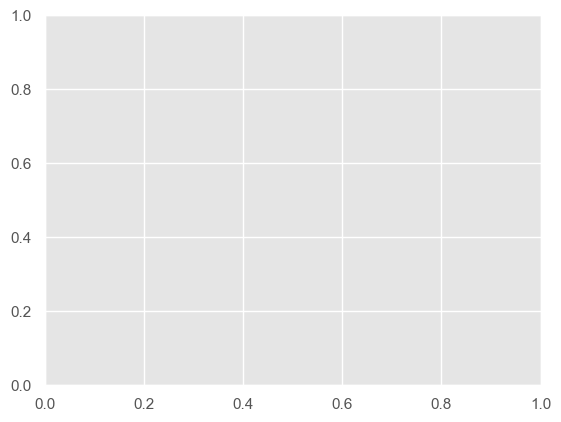

In [71]:
d
# px.line(d,x='date_month',y='created_at')
sns.lineplot(data=d,x='date_month',y='created_at')


In [29]:
df[(~df.has_image) & (df.has_attachement)].iloc[2]['attachments']

[{'loci': [[0, 12]], 'type': 'mentions', 'user_ids': ['32644422']}]

In [67]:
df.groupby('name_y')['created_at'].count().sort_values(ascending=False)

name_y
Michael Hubbell       910
Sam Chastain          479
John Marston          455
Joe Cretini           343
Mary Dicharry         247
Taylor Stirling       245
Matthew Ruiz          210
Brennan Major         196
Jaxson Pinard         114
Jordi Osuna           114
Matt Morales          109
Sam Wetzel            100
Joe Stassi             97
Adam Henderson         96
Matthew Hubbell        86
Nic Brooksher          67
Pierce Hill            55
Diego Matus            50
Paul Cobler            39
Stallion Green         37
Ethan Barbin           33
William Delaune        26
Matt Comeaux           21
Graham Vogt            21
Matt Wallace           18
Christian Nunley       18
Connor Hurd            16
Easton hollis          14
James Finn             12
Andrew Searles         11
Reid Upthegrove        11
Dalton Major           10
Gregory Roy             9
Matthew Crapanzano      9
Nick Baldwin            7
Michael Ruiz            7
Terell Wilkins          7
Clayton McGee           6
Zach 

In [56]:
df[df.has_attachement == True]
df[df.attachement_num > 1].iloc[0]['attachments']

[{'type': 'image',
  'url': 'https://i.groupme.com/992x744.jpeg.6596b885bcaa4a0f8a5e9282d21f6495'},
 {'type': 'image',
  'url': 'https://i.groupme.com/1000x1332.jpeg.5e4b23bb3b75432caf554e0e33aa17c4'}]

In [42]:
df.iloc[1]['attachments']

[{'loci': [[26, 11]], 'type': 'mentions', 'user_ids': ['22089390']}]

In [40]:
# There are some messages that aren't from a personL
# df[df.sender_type != 'user']
df.group_id.value_counts()

53526472    4465
Name: group_id, dtype: int64